# thal2 4:3 Bifurcation Diagrams

# Inits

## Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max,follow_phase_diffs_v2)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thal0_85_1k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_1k',**kws1)

mkdir ./data/thal0_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 4:3

In [13]:
het_coeffs = [1,1000]

In [14]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (4,3)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 43 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


### Plot 1par eps

<Axes: >

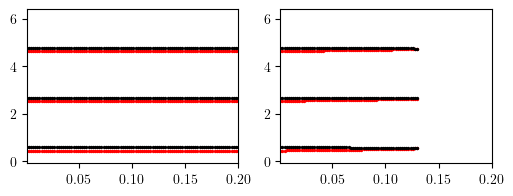

In [58]:
etup = (.001,.2,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=.00197,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

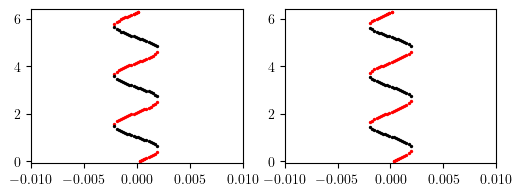

In [14]:
dtup12 = (-.01,.01,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

## EPS VARY

In [19]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [20]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [21]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.00197

#### Branches eps stable

In [92]:
b=.00197
kw_b['recompute'] = False
kw_b['b'] = b

In [130]:
in_dicts = [
    dict(phi0=1,eps_init=0.050,eps_final=0,deps=-.01),
    dict(phi0=1,eps_init=0.050,eps_final=.2,deps=.005),
]

In [94]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [131]:
# data_bs_list = []
in_dicts = [
    dict(phi0=1,eps_init=0.050,eps_final=0,deps=-.01),
    dict(phi0=1,eps_init=0.050,eps_final=.2,deps=.005),
    dict(phi0=1,eps_init=0.085,eps_final=.2,deps=.005),
]

eps_list = []
tsx_list = []
tsy_list = []
tdiffs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    eps_range,tsx,tsy,tdiffs = follow_phase_diffs_v2(tol=1e-6,**in1,**kw_b)
    # try first index
    eps_list.append(eps_range)
    tsx_list.append(tsx)
    tsy_list.append(tsy)
    tdiffs_list.append(tdiffs)
    #dat = np.zeros([len(eps_range),2]) 
    print(tdiffs)
    #dat[:,0] = eps_range
    #dat[:,1] = np.mod(-2*np.pi*np.mean(tdiffs[:,::a._n[1]],axis=1)/np.mean(tsx,axis=1),2*np.pi)
    # print()

phi init 1
[[3.49310302 5.55716389 7.61722465 3.98711759 6.04717835 8.13723999 2.41507123 4.47513198 6.56519362 2.93108645 5.02114809 7.08420893]
 [3.49610311 5.56516413 7.63222509 3.99511783 6.06217879 8.15324046 2.42307146 4.49013243 6.5811941  2.94208677 5.03214841 7.10220946]
 [3.4991032  5.57516443 7.64822557 4.00411809 6.07717923 8.16924093 2.43307176 4.5061329  6.5981946  2.95208706 5.04314874 7.11920996]
 [       nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan]
 [0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]]
phi init 1
[[3.49310302 5.55716389 7.61722465 3.98711759 6.04717835 8.13723999 2.41507123 4.47513198 6.56519362 2.93108645 5.02114809 7.08420893]
 [3.49210299 5.55316378 7.60922442 3.98311747 6.03917811 8.12923975 2.41107111 4.46713175 6.55719339 2.9260863  5.01514791 7.07520867]
 [3.49110296 5.54816363 7.602224

In [96]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [66]:
# kw_b['recompute'] = False
# kw_b['b'] = b

In [67]:
# _,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [68]:
# in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
#             dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.005),
#            ]

In [69]:
data_bu_list = []
# # Y=Yinit
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
#     data_bu_list.append(dat)

In [70]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

In [129]:
eps_list[1][7]

0.08499999999999999

In [138]:
tsx_list

[array([[1.5700463 , 1.52804507, 1.54304551, 1.57204636],
        [1.5700463 , 1.5360453 , 1.54904569, 1.57204636],
        [1.5700463 , 1.54504557, 1.55404583, 1.57204636],
        [       nan,        nan,        nan,        nan],
        [0.        , 0.        , 0.        , 0.        ]]),
 array([[1.5700463 , 1.52804507, 1.54304551, 1.57204636],
        [1.5700463 , 1.52404495, 1.54104545, 1.57204636],
        [1.56904628, 1.52004483, 1.53904539, 1.57204636],
        [1.5700463 , 1.51504468, 1.5360453 , 1.57304639],
        [1.56904628, 1.51204459, 1.53304521, 1.57304639],
        [1.5700463 , 1.50704445, 1.53104515, 1.57304639],
        [1.5700463 , 1.50404436, 1.52804507, 1.57304639],
        [1.56904628, 1.50004424, 1.52604501, 1.57304639],
        [       nan,        nan,        nan,        nan],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0. 

C:\Users\park.y\AppData\Local\Temp\ipykernel_16652\3616963465.py:8: RuntimeWarning: invalid value encountered in divide
  axs[1].plot(eps_list[0],np.mod(tdiffs_list[0][:,0]/np.sum(tsx_list[0],axis=1),1))
C:\Users\park.y\AppData\Local\Temp\ipykernel_16652\3616963465.py:9: RuntimeWarning: invalid value encountered in divide
  axs[1].plot(eps_list[1],np.mod(tdiffs_list[1][:,0]/np.sum(tsx_list[1],axis=1),1))


(0.2, 0.6)

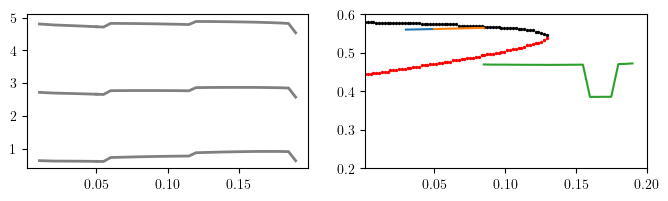

In [145]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)



axs[1].plot(eps_list[0],np.mod(tdiffs_list[0][:,0]/np.sum(tsx_list[0],axis=1),1))
axs[1].plot(eps_list[1],np.mod(tdiffs_list[1][:,0]/np.sum(tsx_list[1],axis=1),1))
axs[1].plot(eps_list[2],np.mod(tdiffs_list[2][:,0]/np.sum(tsx_list[2],axis=1),1))


T = np.sum(tsx_list[0][0,:])
axs[1].plot(eps_list[0],3*tdiffs_list[0][:,1]/T)
axs[1].plot(eps_list[1],3*tdiffs_list[1][:,1]/T)

axs[1].plot(eps_list[0],6*tdiffs_list[0][:,2]/T)
axs[1].plot(eps_list[1],6*tdiffs_list[1][:,2]/T)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

axs[1].set_ylim(.2,.6)

In [105]:
eps_list

[array([0.05, 0.04, 0.03, 0.02, 0.01]),
 array([0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185, 0.19 , 0.195, 0.2  ])]

In [72]:
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
# print(es_min,phi0)

#### Monodromys min

In [51]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# b_min_all.append(b)
# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [52]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.0019

#### Branches eps stable

In [73]:
b=.0019
kw_b['recompute'] = False
kw_b['b'] = b

In [74]:
in_dicts = [
    dict(phi0=1,eps_init=0.050,eps_final=0,deps=-.01),
    dict(phi0=1,eps_init=0.050,eps_final=.2,deps=.005),
]

In [75]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
period_est 6.210062100621006 time_est 997.1099710997111
iter, eps phase_diffs 0 0.05 [0.63359682 4.74661696 2.68323096]                
iter, eps phase_diffs 1 0.04 [0.63830786 4.76601855 2.69691628]                
iter, eps phase_diffs 2 0.03 [0.64273579 4.78588477 2.71028311]                
iter, eps phase_diffs 3 0.019999999999999997 [0.64571713 4.8037015  2.72270024]                
iter=1, rel. err =2.51e+01                                              
data1 shape [[0.05       1.55345378 1.55345378 1.55345378 0.63359682 4.74661696 2.68323096]
 [0.04       1.55675379 1.55675379 1.55675379 0.63830786 4.76601855 2.69691628]
 [0.03       1.5602038  1.5602038  1.5602038  0.64273579 4.78588477 2.71028311]
 [0.02       1.56370381 1.56370381 1.56370381 0.64571713 4.8037015  2.72270024]
 [0.01              nan        nan        nan        nan        nan        nan]]
phi init 1
period_est 6.210062100621006 time_est 997.1099710997111
iter, eps phase_diffs 0 0.05 [0.63359682 4.7

In [76]:
# data_bs_list = []
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     eps_range,tsx,tsy,tdiffs = follow_phase_diffs_v2(tol=1e-8,**in1,**kw_b)
#     # try first index
#     dat = np.zeros([len(eps_range),2]) 
#     print(tdiffs)
#     dat[:,0] = eps_range
#     dat[:,1] = np.mod(-2*np.pi*np.mean(tdiffs[:,::a._n[1]],axis=1)/np.mean(tsx,axis=1),2*np.pi)
#     # print()

In [77]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [78]:
# kw_b['recompute'] = False
# kw_b['b'] = b

In [79]:
# _,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [80]:
# in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
#             dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.005),
#            ]

In [81]:
data_bu_list = []
# # Y=Yinit
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
#     data_bu_list.append(dat)

In [82]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

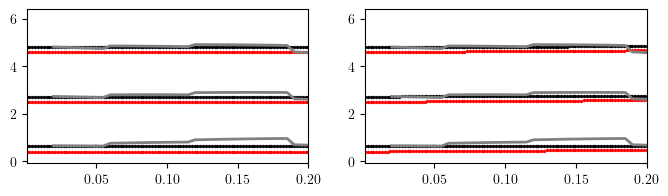

In [84]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [72]:
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
# print(es_min,phi0)

#### Monodromys min

In [51]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# b_min_all.append(b)
# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [52]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.002

#### Branches eps stable

In [22]:
b=-.002
kw_b['recompute'] = False
kw_b['b'] = b

In [23]:
# in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
#             dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.005)]

In [45]:
in_dicts = [
    dict(phi0=1.5,eps_init=0.050,eps_final=0,deps=-.01),
    dict(phi0=1.5,eps_init=0.050,eps_final=.2,deps=.005,tol=1e-9),
]

In [46]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1.5
phi init 1.5
period_est 6.210062100621006 time_est 998.009980099801
iter, eps phase_diffs 0 0.05 [3.50648477 1.46118706 5.60600543]                
iter, eps phase_diffs 1 0.055 [3.50668216 1.4668395  5.60728868]                
iter=20, rel. err =2.73e-07                                              
data1 shape [[0.05       1.55275378 1.55275378 1.55275378 3.50648477 1.46118706 5.60600543]
 [0.055      1.55105378 1.55105378 1.55105378 3.50668216 1.4668395  5.60728868]
 [0.06              nan        nan        nan        nan        nan        nan]
 [0.065             nan        nan        nan        nan        nan        nan]
 [0.07              nan        nan        nan        nan        nan        nan]
 [0.075             nan        nan        nan        nan        nan        nan]
 [0.08              nan        nan        nan        nan        nan        nan]
 [0.085             nan        nan        nan        nan        nan        nan]
 [0.09              nan        n

In [32]:
# data_bs_list = []
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     eps_range,tsx,tsy,tdiffs = follow_phase_diffs_v2(tol=1e-8,**in1,**kw_b)
#     # try first index
#     dat = np.zeros([len(eps_range),2]) 
#     print(tdiffs)
#     dat[:,0] = eps_range
#     dat[:,1] = np.mod(-2*np.pi*np.mean(tdiffs[:,::a._n[1]],axis=1)/np.mean(tsx,axis=1),2*np.pi)
#     # print()

In [33]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [34]:
# kw_b['recompute'] = False
# kw_b['b'] = b

In [35]:
# _,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [36]:
# in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
#             dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.005),
#            ]

In [37]:
data_bu_list = []
# # Y=Yinit
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
#     data_bu_list.append(dat)

In [38]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

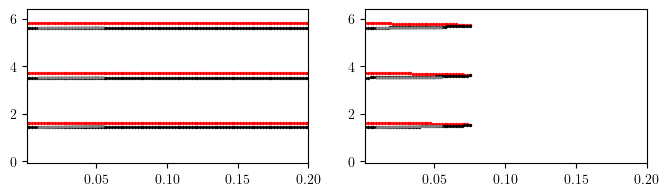

In [49]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [50]:
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
# print(es_min,phi0)

#### Monodromys min

In [51]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# b_min_all.append(b)
# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [52]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [47]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# data = np.loadtxt('../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg2.dat'
data3 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg3.dat'
data4 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.1, 0.05)

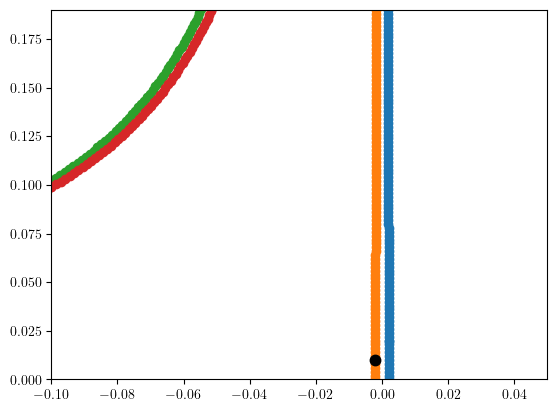

In [48]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])
axs.scatter(data3[:,1],data3[:,0])
axs.scatter(data4[:,1],data4[:,0])

axs.set_ylim(0,.19)
axs.set_xlim(-.1,.05)

# Eigenvalue Convergence Plot

## Min

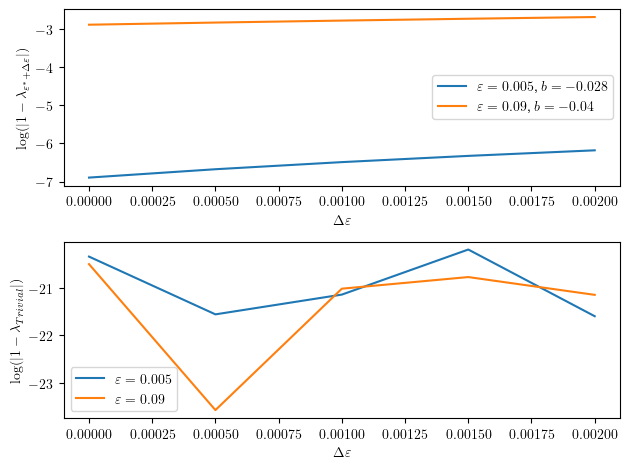

In [107]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 2

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

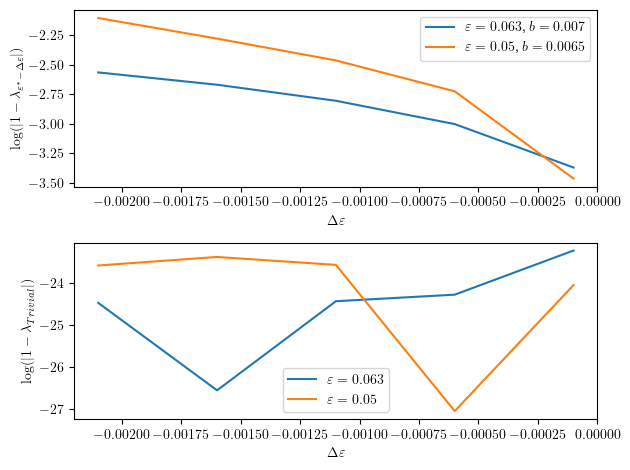

In [257]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_max_{}{}.png'.format(a._n[1],a._m[1]))